In [52]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import bech_helper as helper
from tqdm import tqdm
import sys

# Create the dataset

In [53]:
import os
import pandas as pd

dataset_dir = "././../../Data/Bench_data/"

In [54]:
class CustomDataset(Dataset):
    """Custom dataset for the benchmark dataset
    Args:
        root_dir (string): Directory with all the videos.
        createCSV (bool): If true, creates the csv files for the dataset and saves them in the same directory as the video.
        createBBOX (bool): If true, creates the bounding boxes for the dataset and saves them in the same directory as the video.

    """

    def __init__(self, root_dir, createCSV=False, createBBOX=False):
        self.root_dir = root_dir
        self.video_files = []
        self.csv_files = []
        self.bbox_files = []
        self.net = cv2.dnn.readNetFromCaffe(
            prototxt=("../../Models/deploy.prototxt.txt"),
            caffeModel=(
                "../../Models/Facial_recognition/res10_300x300_ssd_iter_140000.caffemodel"
            ),
        )

        if createCSV:
            helper.converter_driver(self.root_dir)

        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith("edited.avi"):
                    video_file = os.path.join(root, file)
                    self.video_files.append(video_file)
                if file.endswith("output.csv"):
                    csv_file = os.path.join(root, file)
                    self.csv_files.append(csv_file)
                if file.endswith("box.csv"):
                    bbox_file = os.path.join(root, file)
                    self.bbox_files.append(bbox_file)
        if createBBOX:
            for i in range(len(self.video_files)):
                video_file = self.video_files[i]
                helper.start_video_feed(video_file, self.net)

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = self.video_files[idx]
        csv_path = self.csv_files[idx]
        bbox_path = self.bbox_files[idx]

        return (video_path, csv_path, bbox_path)

In [55]:
from torch.utils.data import DataLoader

batch_size = 5
dataset = CustomDataset(root_dir=dataset_dir, createCSV=False, createBBOX=False)

In [56]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [57]:
for batch in dataloader:
    (video_path, csv_path, bbox_path) = batch
print(video_path, csv_path, bbox_path)

('././../../Data/Bench_data/P2LC2/P2LC2_edited.avi',) ('././../../Data/Bench_data/P2LC2/P2LC2_Mobi_output.csv',) ('././../../Data/Bench_data/P2LC2/bbox.csv',)


In [58]:
# Add extra files that we need to use
sys.path.append("../Skin_segmentation/")
sys.path.append("../../Models/")

# Import classes
# import skin_detection_runefile as skin_driver
from skin_video_driver import MultipleVideoDriver
from rPPGNet import *
from helper_functions import helper_functions
import random

In [59]:
class CustomDataset(Dataset):
    """Custom dataset for the benchmark dataset
    Args:
        root_dir (string): Directory with all the videos.
        createCSV (bool): If true, creates the csv files for the dataset and saves them in the same directory as the video.
        createBBOX (bool): If true, creates the bounding boxes for the dataset and saves them in the same directory as the video.

    """

    def __init__(
        self, root_dir, createCSV=False, createBBOX=False, frames=64, verbosity=False
    ):
        self.root_dir = root_dir
        self._class = "[Custom dataset]"
        self.video_files = []
        self.videoECG_counter = 0
        self.csv_files = []
        self.bbox_files = []
        self.verbosity = verbosity
        self.frames = frames
        self.videoDriver = MultipleVideoDriver()
        self.net = cv2.dnn.readNetFromCaffe(
            prototxt=("../../Models/deploy.prototxt.txt"),
            caffeModel=(
                "../../Models/Facial_recognition/res10_300x300_ssd_iter_140000.caffemodel"
            ),
        )
        self.start_frame_idx = 1
        self.current_frame_idx = self.start_frame_idx

        if createCSV:
            helper.converter_driver(self.root_dir)

        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith("edited.avi"):
                    video_file = os.path.join(root, file)
                    self.video_files.append(video_file)
                if file.endswith("output.csv"):
                    csv_file = os.path.join(root, file)
                    self.csv_files.append(csv_file)
                if file.endswith("box.csv"):
                    bbox_file = os.path.join(root, file)
                    self.bbox_files.append(bbox_file)
        if createBBOX:
            for i in range(len(self.video_files)):
                video_file = self.video_files[i]
                helper.start_video_feed(video_file, self.net)

    def __len__(self):
        return len(self.video_files)

    def load_video_frames(self, video_path, bbdata, cur_frame_idx):
        print(f"{self._class} Converting")
        mask_array, frame_array = self.videoDriver.convert_video_with_progress(
            video_file=video_path,
            data=bbdata,
            frames_to_process=self.frames + 1,
            starting_frame=cur_frame_idx,
            verbosity=False,
        )
        mask_array = helper_functions.binary_mask(mask_array)
        return mask_array, frame_array

    def load_ecg_data(self, ecg_path, start_frame, end_frame):
        ecg = pd.read_csv(ecg_path)
        ecg = ecg["ECG-A(mV)"]
        ecg = ecg[start_frame : end_frame + 1]
        return ecg

    def __getitem__(self, idx):
        video_path = self.video_files[idx]
        ecg_path = self.csv_files[idx]
        bbox_path = self.bbox_files[idx]

        bb_data = pd.read_csv(bbox_path)
        bb_data = bb_data[["X", "Y", "Width", "Height"]]

        column_mapping = {
            "X": "x",
            "Y": "y",
            "Width": "w",
            "Height": "h",
        }
        # Rename the columns using the dictionary
        bb_data.rename(columns=column_mapping, inplace=True)

        start_frame = self.current_frame_idx
        video_frame_count = helper_functions.get_video_frame_count(video_path)
        end_frame = start_frame + min(self.frames, video_frame_count - start_frame)

        if self.verbosity:
            print(
                f"{self._class} [INFO]: VideoFile: {video_path} | ECGFile: {ecg_path} |"
            )
            print(
                f"{self._class} [INFO]: VideoCounter: {self.videoECG_counter} | FrameCounter: {start_frame} | TotalFrames: {video_frame_count}"
            )

        mask_array, frame_array = self.load_video_frames(
            video_path=video_path, bbdata=bb_data, cur_frame_idx=start_frame
        )
        ecg = self.load_ecg_data(
            ecg_path=ecg_path, start_frame=start_frame, end_frame=end_frame
        )

        skin_seg_label, frame_tensor, ecg_tensor = helper_functions.tensor_transform(
            mask_array, frame_array, ecg, self.frames
        )
        self.current_frame_idx = end_frame

        if (not frame_tensor.shape[1] == self.frames) or (
            not ecg_tensor.shape[0] == self.frames
        ):
            # print("Length of ecg GT", ecg_tensor.shape[0])
            # print("Number of frames:", frame_tensor.shape[1])
            if self.verbosity:
                print(f"{self._class} [DEBUGGING]", start_frame)
                print(
                    f"{self._class} [DEBUGGING] Video frames available",
                    video_frame_count,
                )
                # for i in range(5000):
                print(f"{self._class} [INFO] GETTING NEW VIDEO!")
            self.videoECG_counter += 1
            self.current_frame_idx = self.start_frame_idx
        if end_frame + self.frames >= video_frame_count:
            # Move to the next video
            self.videoECG_counter += 1
            self.current_frame_idx = self.start_frame_idx

        return skin_seg_label, frame_tensor, ecg_tensor

    def get_dataloader(self, batch_size=1, *args, **kwargs):
        if self.purpose == "train":
            return DataLoader(
                dataset=self.train_subset,
                shuffle=True,
                batch_size=batch_size,
                *args,
                **kwargs,
            )
        if self.purpose == "test":
            return DataLoader(
                dataset=self.test_subset,
                shuffle=False,
                batch_size=batch_size,
                *args,
                **kwargs,
            )
        if self.purpose == "val":
            return DataLoader(
                dataset=self.val_subset,
                shuffle=False,
                batch_size=batch_size,
                *args,
                **kwargs,
            )

In [60]:
from torch.utils.data import DataLoader

batch_size = 1
dataset = CustomDataset(
    root_dir=dataset_dir, createCSV=False, createBBOX=False, verbosity=True
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [61]:
for batch in dataloader:
    skin_seg_label, frame_tensor, ecg_tensor = batch

[Custom dataset] [INFO]: VideoFile: ././../../Data/Bench_data/P1LC1/P1LC1-edited.avi | ECGFile: ././../../Data/Bench_data/P1LC1/P1LC1_Mobi_output.csv |
[Custom dataset] [INFO]: VideoCounter: 0 | FrameCounter: 1 | TotalFrames: 5567
[Custom dataset] Converting
[Custom dataset] [INFO]: VideoFile: ././../../Data/Bench_data/P1LC2/P1LC2_edited.avi | ECGFile: ././../../Data/Bench_data/P1LC2/P1LC2_Mobi_output.csv |
[Custom dataset] [INFO]: VideoCounter: 0 | FrameCounter: 65 | TotalFrames: 5562
[Custom dataset] Converting
[Custom dataset] [INFO]: VideoFile: ././../../Data/Bench_data/P1H1/P1H1_edited.avi | ECGFile: ././../../Data/Bench_data/P1H1/P1H1_Mobi_output.csv |
[Custom dataset] [INFO]: VideoCounter: 0 | FrameCounter: 129 | TotalFrames: 9019
[Custom dataset] Converting
[Custom dataset] [INFO]: VideoFile: ././../../Data/Bench_data/P1M1/P1M1_edited.avi | ECGFile: ././../../Data/Bench_data/P1M1/P1M1_Mobi_output.csv |
[Custom dataset] [INFO]: VideoCounter: 0 | FrameCounter: 193 | TotalFrames: 

In [62]:
csv_path[0]

'././../../Data/Bench_data/P2LC2/P2LC2_Mobi_output.csv'

In [63]:
df = pd.read_csv(csv_path[0])
df.head(100)

,SampleNBR,TimeStamp,ECG-A(mV),MARKER(-),SAW(-)
0,1,46970.2231,-14.499475,0,0
1,2,46970.2247,-14.492854,0,0
2,3,46970.2262,-14.482703,0,0
3,4,46970.2278,-14.476681,0,0
4,5,46970.2294,-14.458151,0,0
...,...,...,...,...,...
95,96,46970.3625,-14.100129,0,10
96,97,46970.3635,-14.088476,0,12
97,98,46970.3645,-14.089612,0,12
98,99,46970.3655,-14.096892,0,12


In [64]:
ecg = df["ECG-A(mV)"]

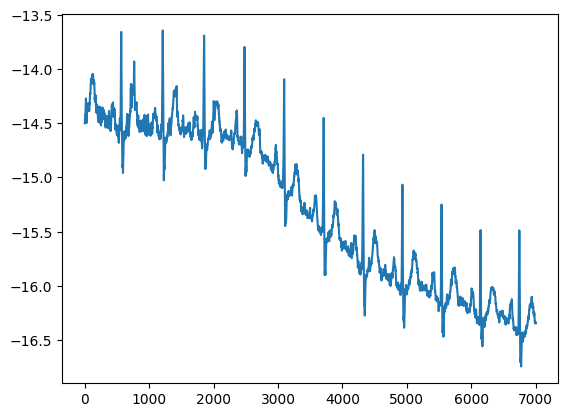

In [65]:
import matplotlib.pyplot as plt

plt.plot(ecg[0:7000])

## Training

In [47]:
from dataloader import BenchDataset

In [51]:
print(os.getcwd())

/home/peetz/Documents/GitHub/Eulerian_Magnificaiton/Code/Dev_notebooks


In [69]:
dataset_

'././../../Data/Bench_data/'

In [68]:
BenchDataset(dataset_dir, createCSV=False, createBBOX=False)

/home/peetz/Documents/GitHub/Eulerian_Magnificaiton/Code/Dev_notebooks


error: OpenCV(4.8.1) /io/opencv/modules/dnn/src/caffe/caffe_io.cpp:1126: error: (-2:Unspecified error) FAILED: fs.is_open(). Can't open "Models/deploy.prototxt.txt" in function 'ReadProtoFromTextFile'
